# Import Library

In [ ]:
#!pip install tensorflowjs

In [ ]:
#!pip install --upgrade pip
#!pip install tensorflow

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import ResNet50


# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Collecting

In [ ]:
!kaggle datasets download -d ichsanelf/private-dataset
!unzip private-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Angry/344.jpg   
  inflating: Dataset/Angry/345.jpg   
  inflating: Dataset/Angry/346.jpg   
  inflating: Dataset/Angry/349.jpg   
  inflating: Dataset/Angry/35.jpg    
  inflating: Dataset/Angry/350.jpg   
  inflating: Dataset/Angry/353.jpg   
  inflating: Dataset/Angry/354.jpg   
  inflating: Dataset/Angry/355.jpg   
  inflating: Dataset/Angry/357.jpg   
  inflating: Dataset/Angry/358.jpg   
  inflating: Dataset/Angry/36.jpg    
  inflating: Dataset/Angry/360.jpg   
  inflating: Dataset/Angry/361.jpg   
  inflating: Dataset/Angry/363.jpg   
  inflating: Dataset/Angry/364.jpg   
  inflating: Dataset/Angry/365.jpg   
  inflating: Dataset/Angry/368.jpg   
  inflating: Dataset/Angry/36c8455fe8fa542426ae525cb71d77ed545c2caacc9680b81ea0e282~angry.jpg  
  inflating: Dataset/Angry/37.jpg    
  inflating: Dataset/Angry/370.jpg   
  inflating: Dataset/Angry/370aedd8724ac9883f71ce04ce90c8e50e144e5e3263899496db552e~angry.jpg

In [ ]:
# Define the base path
path = "Dataset/"

# Initialize the dictionary
human_emotion = {}

# Iterate through each subfolder and collect images
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):  # Check if it is a directory
        images = []
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                images.append(os.path.join(folder_path, filename))
        human_emotion[folder] = images

# Print the dictionary to check the result
print(human_emotion.keys())

dict_keys(['Angry', 'Sad', 'Happy'])


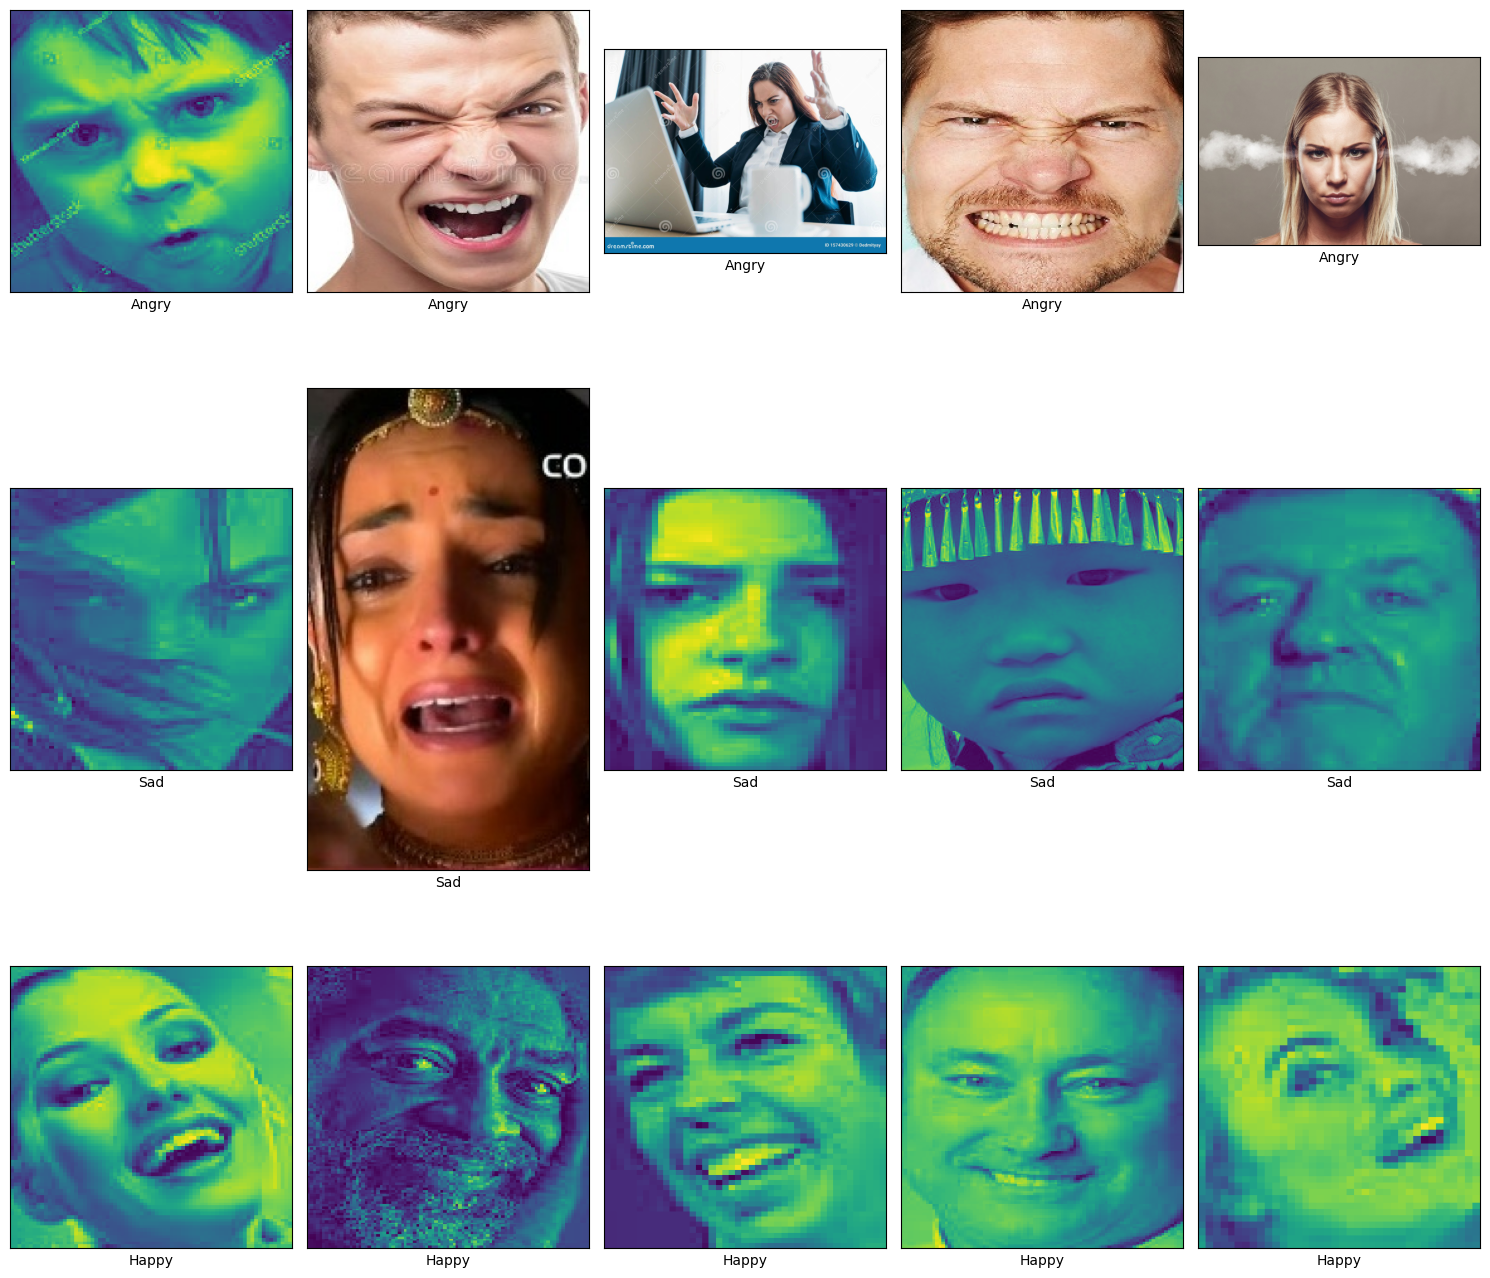

In [ ]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(human_emotion.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(human_emotion.keys()):
    images = np.random.choice(human_emotion[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = human_emotion[class_name][j]
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

# Data Splitting

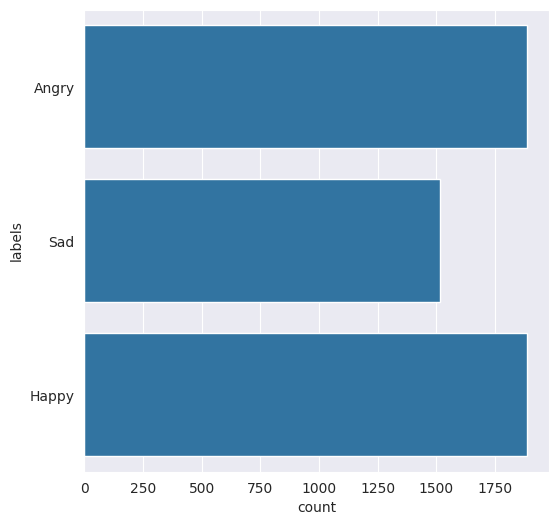

In [ ]:
# Define source path
emotion_path = "Dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(emotion_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

images_df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = images_df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= images_df['path']
y= images_df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 4231
test size 1058


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   Angry      379
       Happy      360
       Sad        319
train  Angry     1508
       Happy     1526
       Sad       1197
dtype: int64 


                                                   path labels    set
497   Dataset/Happy/images - 2020-11-06T194443.081_f...  Happy  train
4944                                Dataset/Sad/659.jpg    Sad   test
4784  Dataset/Angry/images - 2020-11-06T010009.090_f...  Angry   test
618   Dataset/Sad/images - 2020-11-06T200505.028_fac...    Sad  train
4482  Dataset/Angry/5c2111ef46163f9234e1acef6d05d768...  Angry   test


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Model

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

In [ ]:
train_game = {}
for folder in os.listdir(TRAIN_DIR):
    folder_path = os.path.join(TRAIN_DIR, folder)
    if os.path.isdir(folder_path):
        train_game[folder] = len(os.listdir(folder_path))

print(f"Total number of games images in training :", train_game)

test_game = {}
for folder in os.listdir(TEST_DIR):
    folder_path = os.path.join(TEST_DIR, folder)
    if os.path.isdir(folder_path):
        test_game[folder] = len(os.listdir(folder_path))

print(f"Total number of games images in test :", test_game)

Total number of games images in training : {'Angry': 1508, 'Sad': 1197, 'Happy': 1526}
Total number of games images in test : {'Angry': 379, 'Sad': 319, 'Happy': 360}


In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    #zoom_range=0.2,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest',
    )
test_datagen = ImageDataGenerator(rescale=1 / 255.)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=16,
                                              target_size=(200, 200),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                        batch_size=16,
                                                        target_size=(200, 200),
                                                        color_mode="grayscale",
                                                        class_mode='categorical',
                                                        shuffle=False)


Found 4230 images belonging to 3 classes.
Found 1058 images belonging to 3 classes.


In [ ]:
tf.keras.backend.clear_session()
# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Adjust for grayscale input
input_tensor = tf.keras.layers.Input(shape=(200, 200, 1))
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(input_tensor)  # Convert to 3 channels
x = base_model(x)

n_classes=3
# Add custom top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=x)
optimize_lr = Nadam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimize_lr, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,889 (90.00 MB)

 Trainable params: 23,540,769 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
folder_weights = {}

# Calculate the total number of images across all folders
total_classes = len(train_game)
total_images = sum(train_game.values())

# Iterate through each folder and calculate the weight
for folder, count in train_game.items():
    weight = (1 / count) * total_images / total_classes
    folder_weights[folder] = weight

# Print the calculated weights
for folder, weight in folder_weights.items():
    print(f"Weight for {folder}: {weight}")

Weight for Angry: 0.9352343059239611
Weight for Sad: 1.178223336118073
Weight for Happy: 0.9242027086063783


# Evaluasi

## Epoch process

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0000000001)

%time

# Fitting / training model
history_1 = model.fit(train_generator,
                        epochs=50,
                        batch_size=16,
                        validation_data=validation_generator,
                        class_weight = folder_weights,
                        callbacks=[early_stopping, reduce_lr]
                        )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 161s 303ms/step - accuracy: 0.6324 - loss: 0.8267 - val_accuracy: 0.3289 - val_loss: 1.7528 - learning_rate: 1.0000e-04
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 179ms/step - accuracy: 0.8903 - loss: 0.2783 - val_accuracy: 0.3015 - val_loss: 1.5769 - learning_rate: 1.0000e-04
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - accuracy: 0.9575 - loss: 0.1315 - val_accuracy: 0.4216 - val_loss: 1.4692 - learning_rate: 1.0000e-04
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step - accuracy: 0.9642 - loss: 0.0936 - val_accuracy: 0.7136 - val_loss: 0.9502 - learning_rate: 1.0000e-04
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - accuracy: 0.9777 - loss: 0.0750 - val_accuracy: 0.7836 - val_loss: 0.7492 - learning_rate: 1.0000e-04
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 83s 180ms/step - accuracy: 0.9657 - loss: 0.1071 - val_accuracy: 0.7609 - val_loss: 0.9116 - learning_rate: 1.0000e-04
Epoch 7/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 1

## Val acc & loss Plot

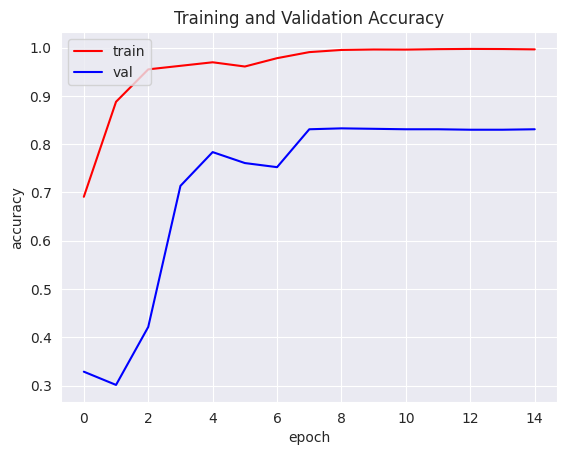

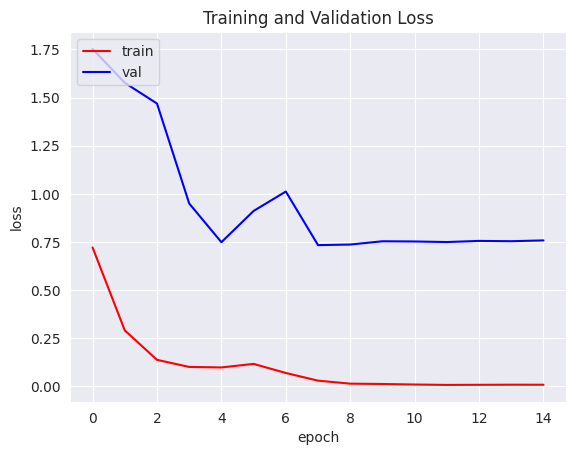

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Confusion Matrix



              precision    recall  f1-score   support

       Angry     0.7873    0.8496    0.8173       379
       Happy     0.9088    0.8861    0.8973       360
         Sad     0.7987    0.7461    0.7715       319

    accuracy                         0.8308      1058
   macro avg     0.8316    0.8273    0.8287      1058
weighted avg     0.8321    0.8308    0.8307      1058



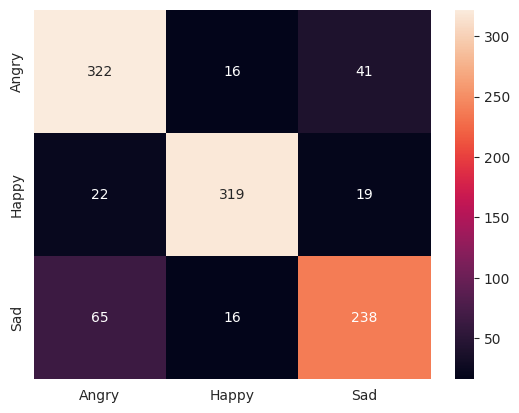

In [ ]:
validation_generator.reset()

preds_1 = model.predict(validation_generator,verbose=0)

predicted_labels = np.argmax(preds_1, axis=1)

cm = pd.DataFrame(data=confusion_matrix(validation_generator.classes, predicted_labels),
                  index=train_generator.class_indices,
                  columns=train_generator.class_indices)

sns.heatmap(cm,annot=True,fmt="d")

print("\n")
print(classification_report(y_true=validation_generator.classes,
                            y_pred=predicted_labels,
                            target_names = train_generator.class_indices,
                            digits=4))

# Konversi Model

tf.keras.backend.clear_session()
## SavedModel

In [ ]:
#tf.keras.backend.clear_session()

#save_path = 'mymodel/'
#tf.saved_model.save(model, save_path)

## Tensorflow.js

In [ ]:
#!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --quantize_uint8 /content/mymodel /content/tfjs_model

2025-01-15 12:13:59.408011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736943239.462086   54550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736943239.472189   54550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Please consider using --quantize_uint8, --quantize_uint16, --quantize_float16.
2025-01-15 12:14:04.402119: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1736943244.

In [ ]:
# prompt: download tfjs_model folder

#!zip -r /content/savedmodel.zip /content/mymodel
#from google.colab import files
#files.download("/content/savedmodel.zip")

updating: content/mymodel/ (stored 0%)
updating: content/mymodel/saved_model.pb (deflated 92%)
updating: content/mymodel/fingerprint.pb (stored 0%)
updating: content/mymodel/assets/ (stored 0%)
updating: content/mymodel/variables/ (stored 0%)
updating: content/mymodel/variables/variables.index (deflated 78%)
updating: content/mymodel/variables/variables.data-00000-of-00001 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inference

Saving human-expressions-emotions-young-attractive-man-sad-face-looking-depressed-unhappy-close-up-portrait-handsome-crying-139799701.webp to human-expressions-emotions-young-attractive-man-sad-face-looking-depressed-unhappy-close-up-portrait-handsome-crying-139799701.webp


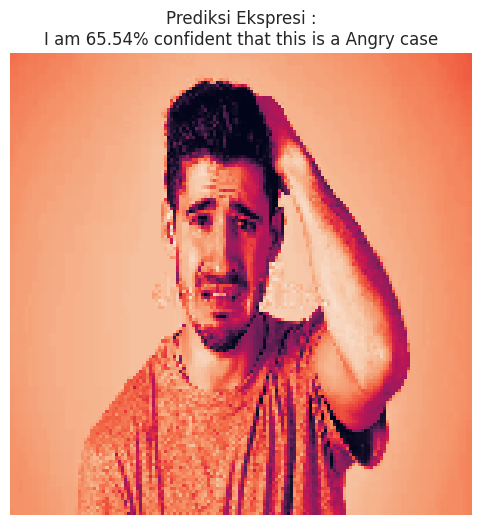

In [ ]:

from google.colab import files
uploaded = files.upload()

# Path to your saved model (adjust as necessary)
model_path = '/content/mymodel/'

# Load the model
model = tf.saved_model.load(model_path)

# Prepare input data
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(150, 150), color_mode="grayscale")
input_arr = image.img_to_array(img)
input_arr = np.array([input_arr])
input_arr = input_arr / 255.
infer = model.signatures["serving_default"]
predictions = infer(tf.constant(input_arr))['output_0']

predictions_array = predictions.numpy()
predicted_class = np.argmax(predictions_array)

class_indices_ = validation_generator.class_indices
index_to_class = {v: k for k, v in class_indices_.items()}

predicted_class_name = index_to_class[predicted_class]

plt.figure(figsize=(6, 6))
plt.axis('off')
out = f"I am {max(predictions_array[0]) * 100:.2f}% confident that this is a {predicted_class_name} case"
plt.title("Prediksi Ekspresi :\n" + out)
plt.imshow(np.squeeze(input_arr))  # Ensuring the image is displayed in grayscale
plt.show()


In [ ]:
!pip freeze > requirements.txt

In [ ]:
# Read the file and filter the lines
with open('requirements.txt', 'r') as f:
    lines = f.readlines()

# Define the packages you want to keep
required_packages = ['pandas', 'matplotlib', 'PIL', 'skimage', 'random',
                     'keras', 'tensorflow', 'tqdm', 'numpy', 'seaborn', 'pathlib'
                    'sklearn', 'os', 'cv2', 'shutil', 'random', 'pathlib']

# Filter the lines
filtered_lines = [line for line in lines if any(package in line for package in required_packages)]

# Write the filtered lines to a new requirements file
with open('requirements.txt', 'w') as f:
    f.writelines(filtered_lines)

# Display the contents of the new requirements file
!cat requirements.txt

aiosignal==1.3.2
blosc2==3.0.0
cloudpathlib==0.20.0
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
geopandas==1.0.1
googleapis-common-protos==1.66.0
ipyfilechooser==0.6.0
keras==3.8.0
librosa==0.10.2.post1
matplotlib==3.10.0
matplotlib-inline==0.1.7
matplotlib-venn==1.1.1
numpy==1.26.4
osqp==0.6.7.post3
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.26.1
pandas-stubs==2.2.2.240909
pathlib==1.0.1
qdldl==0.1.7.post5
scs==3.2.7.post2
seaborn==0.13.2
sklearn-pandas==2.2.0
soxr==0.5.0.post1
tensorflow==2.18.0
tensorflow-datasets==4.9.7
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.16.1
tensorflow-probability==0.24.0
tensorflow_decision_forests==1.11.0
tensorflowjs==4.22.0
tf_keras==2.18.0
tqdm==4.67.1
xgboost==2.1.3


In [4]:
!nbstripout capstone.ipynb

Could not strip 'capstone.ipynb': file not found


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!nbstripout /content/drive/MyDrive/ColabNotebooks/capstone.ipynb